In [ ]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 박스 플롯 hue 구현 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
tips = sns.load_dataset('tips')

# 데이터 준비
days = tips['day'].unique()
smokers = tips['smoker'].unique()

plt.figure(figsize=(8, 5))

# 각 day와 smoker 그룹별로 박스플롯 그리기
positions = []
data_to_plot = []
pos = 1

for day in sorted(days):  # day 순서대로
    for smoker in sorted(smokers):  # smoker = No, Yes
        group = tips[(tips['day'] == day) & (tips['smoker'] == smoker)]['total_bill']
        data_to_plot.append(group)
        positions.append(pos)
        pos += 1
    pos += 1  # day 사이 간격

# 박스플롯 그리기
bp = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

# 색상 채우기 (smoker 구분)
colors = ['lightblue', 'lightcoral'] * len(days)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# x축 레이블: day 가운데 배치
xticks = []
xlabels = []
for i, day in enumerate(sorted(days)):
    xticks.append((i* (len(smokers)+1)) + 1.5)  # day 그룹의 중앙
    xlabels.append(day)

plt.xticks(xticks, xlabels)
plt.xlabel("day")
plt.ylabel("total_bill")
plt.title('Total Bill Distribution by Day and Smoker')

# 범례 추가
from matplotlib.patches import Patch
legend_handles = [Patch(color='lightblue', label='No'),
                  Patch(color='lightcoral', label='Yes')]
plt.legend(handles=legend_handles, title="smoker")

plt.show()

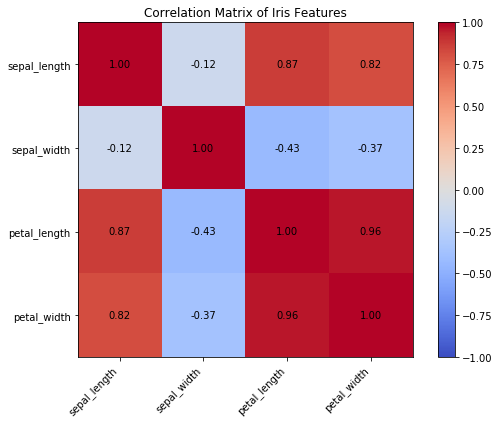

In [49]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 heatmap 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
iris = sns.load_dataset('iris')

# 수치형 변수 간 상관계수 계산
corr = iris.corr()

# 히트맵 그리기
fig, ax = plt.subplots(figsize=(8, 6))

# imshow로 색상 맵 시각화
cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)

# 컬럼 이름으로 x, y축 라벨 설정
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# 각 셀에 상관계수 값 표시
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', color='black')

# 컬러바 추가
fig.colorbar(cax)

plt.title('Correlation Matrix of Iris Features')
plt.tight_layout()
plt.show()


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [96]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# 1. 데이터 생성 (두 개의 상호 연관된 시계열)
np.random.seed(42)
data = np.zeros((100, 2))
for i in range(1, 100):
    data[i, 0] = 0.5 * data[i-1, 0] + 0.2 * data[i-1, 1] + np.random.randn()
    data[i, 1] = 0.3 * data[i-1, 0] + 0.6 * data[i-1, 1] + np.random.randn()

df_var = pd.DataFrame(data, columns=['series1', 'series2'])

# 2. 정상성 확인 (ADF 검정)
# VAR 모델은 모든 시계열이 정상성을 만족해야 함.
# 비정상 시계열인 경우 차분 필요.
print("--- VAR 모델을 위한 정상성 검정 ---")
for name, series in df_var.items():
    result = adfuller(series)
    print(f'{name}: p-value = {result[1]:.3f}')
    if result[1] > 0.05:
        print(f'{name}은 비정상 시계열입니다. 차분이 필요할 수 있습니다.')

# 3. VAR 모델 학습
# maxlags: 고려할 최대 시차.
model_var = VAR(df_var)
results_var = model_var.fit(maxlags=5, ic='aic') # ic='aic'로 최적 시차 자동 선택
print("\n--- VAR 모델 결과 ---")
print(results_var.summary())

# 4. 예측
lag_order = results_var.k_ar
forecast_input = df_var.values[-lag_order:]
forecast_var = results_var.forecast(y=forecast_input, steps=10)
forecast_df_var = pd.DataFrame(forecast_var, index=pd.date_range(start=df_var.index[-1] + 1, periods=10), columns=['series1_pred', 'series2_pred'])

print("\n--- VAR 예측 결과 ---")
print(forecast_df_var)

--- VAR 모델을 위한 정상성 검정 ---
series1: p-value = 0.000
series2: p-value = 0.000

--- VAR 모델 결과 ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Oct, 2025
Time:                     22:09:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0426393
Nobs:                     98.0000    HQIC:                 -0.114442
Log likelihood:          -257.276    FPE:                   0.801752
AIC:                    -0.221133    Det(Omega_mle):        0.725802
--------------------------------------------------------------------
Results for equation series1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.154280         0.090785           -1.699           0.089
L1.series1         0.456790         0.102530         

In [98]:
!pip install prophet

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 13.3/13.3 MB 32.8 MB/s eta 0:00:00
   ---------------------------------------- 83.2/83.2 kB ? eta 0:00:00
   --------------------------------------- 598.5/598.5 kB 39.2 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Attempting uninstall: zipp
    Found existing installation: zipp 0.6.0
    Uninstalling zipp-0.6.0:
      Successfully uninstalled zipp-0.6.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.35.0
    Uninstalling tqdm-4.35.0:
      Successfully uninstalled tqdm-4.35.0
  Attempting uninstall: holidays
    Found existing installation: holidays 0.9.11
    Uninstalling holidays-0.9.11:
      Successfully uninstalled holidays-0.9.11


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.0.0 requires pydantic>=1.8.1, which is not installed.
pandas-profiling 3.0.0 requires tangled-up-in-unicode==0.1.0, which is not installed.
pandas-profiling 3.0.0 requires visions[type_image_path]==0.7.1, which is not installed.
pandas-profiling 3.0.0 requires jinja2>=2.11.1, but you have jinja2 2.10 which is incompatible.
pandas-profiling 3.0.0 requires matplotlib>=3.2.0, but you have matplotlib 3.0.3 which is incompatible.
pandas-profiling 3.0.0 requires phik>=0.11.1, but you have phik 0.9.8 which is incompatible.
pandas-profiling 3.0.0 requires requests>=2.24.0, but you have requests 2.21.0 which is incompatible.
pandas-profiling 3.0.0 requires seaborn>=0.10.1, but you have seaborn 0.9.0 which is incompatible.


Importing plotly failed. Interactive plots will not work.
22:17:32 - cmdstanpy - INFO - Chain [1] start processing
22:17:32 - cmdstanpy - INFO - Chain [1] done processing


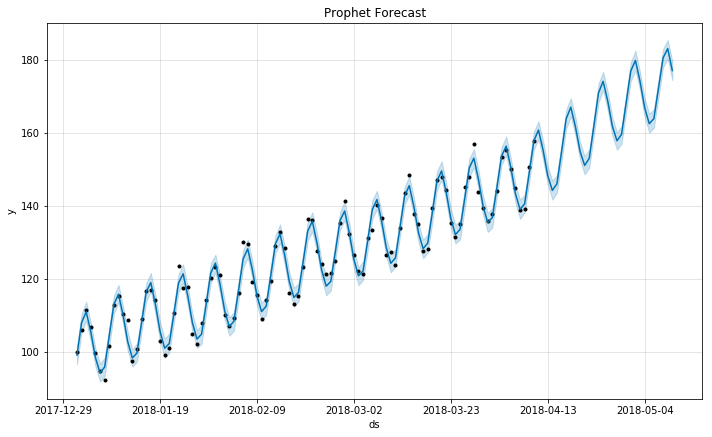

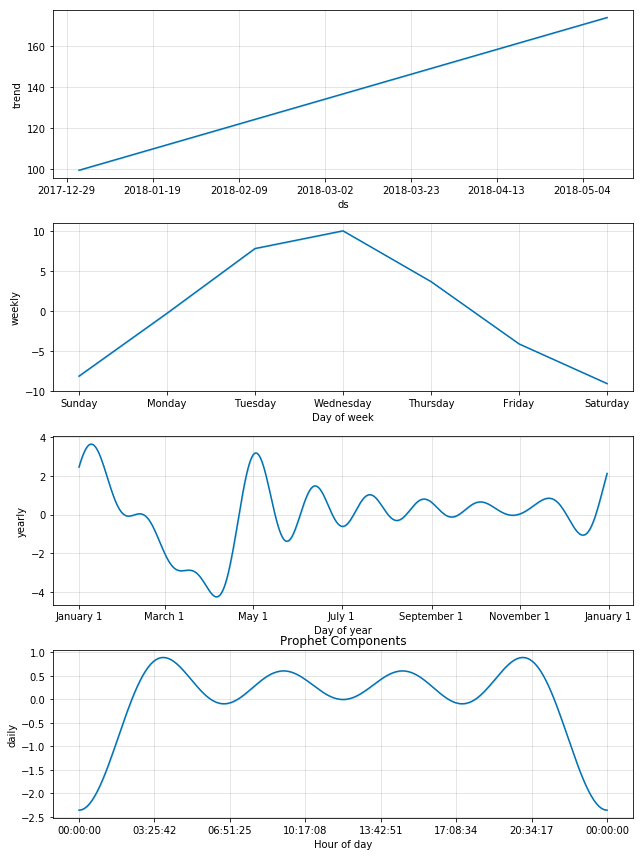

In [99]:
# !pip install prophet
from prophet import Prophet

# 1. 데이터 준비 (Prophet은 'ds'와 'y' 컬럼 필요)
df_prophet = pd.DataFrame({
    'ds': pd.to_datetime(pd.date_range(start='2018-01-01', periods=100, freq='D')),
    'y': 100 + np.arange(100) * 0.5 + 10 * np.sin(np.arange(100) * 2 * np.pi / 7) + np.random.randn(100) * 2
})

# 2. Prophet 모델 학습
# seasonality_mode: 계절성 유형 ('additive' 또는 'multiplicative')
# daily_seasonality, weekly_seasonality, yearly_seasonality: 각 계절성 자동 감지 여부
m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(df_prophet)

# 3. 미래 데이터프레임 생성 및 예측
future = m.make_future_dataframe(periods=30) # 30일 미래 예측
forecast_prophet = m.predict(future)

# 4. 결과 시각화
fig = m.plot(forecast_prophet)
plt.title('Prophet Forecast')
plt.show()

fig2 = m.plot_components(forecast_prophet)
plt.title('Prophet Components')
plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


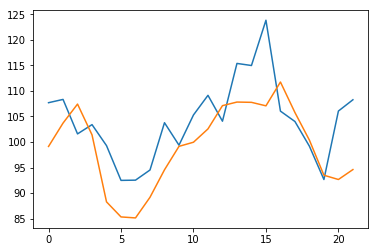

In [100]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 준비 (시계열 데이터를 지도 학습 형태로 변환)
# 예시: 이전 10일 데이터로 다음 1일 예측
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# 데이터 스케일링
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_lstm.fit_transform(ts.values.reshape(-1, 1))

look_back = 10
X_lstm, y_lstm = create_dataset(scaled_data, look_back)

# LSTM 입력 형태 (samples, time steps, features)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# 훈련/테스트 분할
train_size_lstm = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[0:train_size_lstm], X_lstm[train_size_lstm:len(X_lstm)]
y_train_lstm, y_test_lstm = y_lstm[0:train_size_lstm], y_lstm[train_size_lstm:len(y_lstm)]

# 2. LSTM 모델 구축
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(look_back, 1)),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# 3. 모델 학습
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=1, verbose=0)

# 4. 예측
train_predict_lstm = model_lstm.predict(X_train_lstm)
test_predict_lstm = model_lstm.predict(X_test_lstm)

# 스케일 역변환
train_predict_lstm = scaler_lstm.inverse_transform(train_predict_lstm)
y_train_lstm_inv = scaler_lstm.inverse_transform(y_train_lstm.reshape(-1, 1))
test_predict_lstm = scaler_lstm.inverse_transform(test_predict_lstm)
y_test_lstm_inv = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1))

# 5. 결과 시각화 (생략, 실제 데이터와 예측값 비교)
plt.plot(y_test_lstm_inv, label='Actual')
plt.plot(test_predict_lstm, label='Predicted')
plt.show()